# Final Exam, Spring 2023: Bike Share

Revision history:
- 1.1: Added clarification note to [ex7]
- 1.0.1: Fixed typos (no code changes) [ex5, ex7, ex8]
- 1.0: Initial release

*All of the header information is important. Please read it.*

**Topics, number of exercises:** This problem builds on your knowledge of Python, pandas, graphs, and clustering. It has **nine (9)** exercises, numbered 0 to **8**. There are **18** available points. However, to earn 100% the threshold is **12** points. (Therefore, once you hit **12** points, you can stop. There is no extra credit for exceeding this threshold.)

**Exercise ordering:** Each exercise builds logically on previous exercises, but you may solve them in any order. That is, if you can't solve an exercise, you can still move on and try the next one. Use this to your advantage, as the exercises are **not** necessarily ordered in terms of difficulty. Higher point values generally indicate more difficult exercises. 

**Demo cells:** Code cells starting with the comment `### define demo inputs` load results from prior exercises applied to the entire data set and use those to build demo inputs. These must be run for subsequent demos to work properly, but they do not affect the test cells. The data loaded in these cells may be rather large (at least in terms of human readability). You are free to print or otherwise use Python to explore them, but we did not print them in the starter code.

**Debugging you code:** Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed (careful when printing large objects, you may want to print the head or chunks of rows at a time).

**Exercise point breakdown:**

- Exercise 0: **1** point
- Exercise 1: **2** points
- Exercise 2: **2** points
- Exercise 3: **1** point — **FREE** (no coding but you **must** submit to the autograder to earn it)
- Exercise 4: **1** point
- Exercise 5: **3** points
- Exercise 6: **4** points
- Exercise 7: **2** points
- Exercise 8: **2** points

**Final reminders:** 

- Submit after **every exercise**
- Review the generated grade report after you submit to see what errors were returned
- Stay calm, skip problems as needed, and take short breaks at your leisure

# Introduction: Bike-share planning #

The New York City metropolitan area has a bike-sharing service called [Citi Bike](https://citibikenyc.com). They need your help analyzing the [data they've collected](https://citibikenyc.com/system-data) about how riders are using the service.

The input data consists of **trip records**. A trip record shows when a user ("rider") picked up a bike and when she returned the bike, possibly at two different stations. Here is a quick visualization of the data: dots are stations and blue lines indicate trips between a pair of stations. (The color and thickness are scaled by how many trips occurred between two spots; you'll write code to reconstruct this picture later.)

![Example viz: path frequences](resource/asnlib/public/path-frequencies.png)

You will help the NYC government with two analytics tasks:

1. analyzing bike inventory, and
2. deciding where to place advertisements for local small-businesses.

Good luck—the city of New York thanks you!

# Setup #

To get started, run the code cell below. It will load a few modules you may find helpful.

In [66]:
### Global Imports
###
### AUTOGRADER TEST - DO NOT REMOVE
###


import sys
import numpy as np
import pandas as pd
import scipy as sp

import cse6040
import cse6040.utils

print("\n=== Package versions in your environment ===")
print("* Python: " +  sys.version.replace('\n', ' '))
print(f"* pandas: {pd.__version__}")
print(f"* numpy: {np.__version__}")
print(f"* scipy: {sp.__version__}")
print(f"* cse6040: {cse6040.__version__}")


=== Package versions in your environment ===
* Python: 3.8.7 (default, Jan 25 2021, 11:14:52)  [GCC 5.5.0 20171010]
* pandas: 1.4.0
* numpy: 1.22.1
* scipy: 1.7.3
* cse6040: 23.04.26


# Part A: Basic dataset cleaning #

Let's start by loading and inspecting the dataset, which will be loaded into a pandas dataframe named `trips`:

In [67]:
trips_raw = pd.concat([cse6040.utils.load_csv(f"JC-2022{mm:02d}-citibike-tripdata.csv", verbose=True, abort_on_error=True) \
                   for mm in [6, 7, 8]], ignore_index=True)
trips_raw['started_at'] = pd.to_datetime(trips_raw['started_at'])
trips_raw['ended_at'] = pd.to_datetime(trips_raw['ended_at'])
print(f"\nTotal number of rows: {len(trips_raw):,}. Here are the first few:")
trips_raw.head()

Loading CSV file, 'resource/asnlib/publicdata/JC-202206-citibike-tripdata.csv'...
  ==> Done! Found 103,299 records (rows).
Loading CSV file, 'resource/asnlib/publicdata/JC-202207-citibike-tripdata.csv'...
  ==> Done! Found 108,502 records (rows).
Loading CSV file, 'resource/asnlib/publicdata/JC-202208-citibike-tripdata.csv'...
  ==> Done! Found 115,231 records (rows).

Total number of rows: 327,032. Here are the first few:


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,EEA3CD3B084370F4,classic_bike,2022-06-30 19:17:16,2022-06-30 19:27:13,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
1,BF568C9B3C5FAE94,classic_bike,2022-06-02 12:46:44,2022-06-02 15:08:33,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
2,DF6B06D460481A7E,classic_bike,2022-06-05 14:17:34,2022-06-05 14:27:12,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
3,A26CDB92CDF7E0EE,electric_bike,2022-06-01 18:57:12,2022-06-01 19:05:58,Clinton St & Newark St,HB409,Pershing Field,JC024,40.737430,-74.035710,40.742677,-74.051789,member
4,A2A50E81031E9E7F,electric_bike,2022-06-14 22:45:53,2022-06-14 22:49:39,Oakland Ave,JC022,Pershing Field,JC024,40.737604,-74.052478,40.742677,-74.051789,member


**Trip records ("trips") & riders**: Each record (row) of the `trips` dataframe corresponds to a trip that a **rider** took. The main information you'll need is the following:
- The rider went to the bike station named `'start_station_name'` at the day and time given by `'started_at'`. The (longitude, latitude) coordinates of that station are given by (`'start_lng'`, `'start_lat'`).
- The rider then used the bike until `'ended_at'`, at which time they returned the bike to the station named `'end_station_name'`. The geographic coordinates of the endpoint are (`'end_lng'`, `'end_lat'`).

## **Exercise 0** (1 pt): `clean_string` ##

Recall that a Python string can have some special whitespace characters. These are "escaped," meaning there is a backslash (`\`) in front. For example, a tab character is the escaped sequence, `'\t'`:

In [68]:
print('abc\txyz')

abc	xyz


The station names may contain such escaped sequences. However, one weird case is that they can **also** contain the **actual** slash-and-t characters:

In [69]:
print(repr(trips_raw['end_station_name'].loc[215_008]))

'Murray St\\t& West St'


Notice that the example above contains the substring `'\\t'`.

Complete the function, `clean_string(s)`, to preprocess a string and replace both instances of escaped-tabs (`'\t'`) and the escaped-slash-and-tee (`'\\t'`) with a single space. In addition, your function should replace substrings of consecutive whitespace characters with a single space. See the example below.

**Inputs**: A Python string, `s`.

**Your task**:
- Replace instances of `'\\t'` with a single space.
- Replace consecutive whitespace (could be `'\t'`, `'\n'`, etc.) with a single space.
- Trim any leading or trailing whitespace.

**Output**: Return the Python-string result.

In [70]:
### Demo input ###

demo_s_ex1 = '  abc\\t\t  \n f38 456  \n\t  ' # Note: '\t' and '\n' are actual whitespace

For the demo input shown above, the result would be:
```python
'abc f38 456'
```

In [71]:
### Exercise 0 solution
def clean_string(s):
    
    import re
    
    s = s.replace('\\t', ' ') # s = s.replace(r'\t', ' ')
    s = re.sub('[\s]+', ' ', s) # s = sub(r'\s+', ' ', s)
    s = s.strip()
    
    return s
    
### demo function call ###
clean_string(demo_s_ex1)

'abc f38 456'

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 0. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [72]:
### test_cell_ex0
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_0', 
    'func': clean_string, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        's':{
            'dtype':'str', # data type of param.
            'check_modified':False,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'str',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Exercise 1** (2 pts): `geo_filter` ##

Every station has geographic (longitude, latitude) coordinates associated with it. Suppose we only want to consider stations whose coordinates fall within a given rectangle. Complete the function `geo_filter(df, a, b)`, below, to assist in this task.

**Inputs**:
- `df`: A dataframe containing at least the columns `'start_lng'`, `'start_lat'`, `'end_lng'`, and `'end_lat'`.
- `a`: A Python pair (tuple) with two coordinates, `(a_lng, a_lat)`.
- `b`: A Python pair (tuple) with two coordinates, `(b_lng, b_lat)`.

**Your task**: Suppose `(x, y)` are the longitude-latitude coordinates of a station. We only want to keep trips where `a_lng <= x <= b_lng` and `a_lat <= y <= b_lat`.

Since each row of `df` has a starting station and an ending station, you need to check both stations. Only keep rows where **both** stations lie within the rectangle.

**Output**: Your function should return a **new** dataframe that has only the rows from `df` matching the criteria explained above.

**Notes**:
1. You may assume that `a_lng <= b_lng` and `a_lat <= b_lat`.
2. An empty dataframe (no rows match) is a possible outcome.

In [73]:
### Define demo inputs ###

demo_a_ex1 = (-74.0668, 40.7011)
demo_b_ex1 = (-74.0256, 40.7486)

demo_df_ex1 = pd.DataFrame({
    'ride_id': ['DD0EAAE52F0A2B4E', 'C9BA237315EBF5C6', 'BE74FEAC74D6F7E9', '445646A328047667']
    , 'start_lng': [-74.0355, -74.0272, -74.0557, -74.0442]
    , 'start_lat': [40.7243, 40.75, 40.7112, 40.7276]
    , 'end_lng': [-74.0278, -74.031, -74.0428, -74.0431]
    , 'end_lat': [40.737, 40.7374, 40.7146, 40.7196]
})

print("=== Demo inputs ===")
display(demo_df_ex1)
print("a =", demo_a_ex1)
print("b =", demo_b_ex1)

=== Demo inputs ===


,ride_id,start_lng,start_lat,end_lng,end_lat
0,DD0EAAE52F0A2B4E,-74.0355,40.7243,-74.0278,40.7370
1,C9BA237315EBF5C6,-74.0272,40.7500,-74.0310,40.7374
2,BE74FEAC74D6F7E9,-74.0557,40.7112,-74.0428,40.7146
3,445646A328047667,-74.0442,40.7276,-74.0431,40.7196


a = (-74.0668, 40.7011)
b = (-74.0256, 40.7486)


For the demo inputs above, a correct `geo_filter` function would return the following:

| ride_id          |   start_lng |   start_lat |   end_lng |   end_lat |
|:-----------------|------------:|------------:|----------:|----------:|
| DD0EAAE52F0A2B4E |    -74.0355 |     40.7243 |  -74.0278 |   40.737  |
| BE74FEAC74D6F7E9 |    -74.0557 |     40.7112 |  -74.0428 |   40.7146 |
| 445646A328047667 |    -74.0442 |     40.7276 |  -74.0431 |   40.7196 |

Observe that row 1 does not appear in the output. That's because the starting latitude, 40.7500, falls outside the target range of (40.7011, 40.74857).

In [74]:
### Exercise 1 solution
def geo_filter(df, a, b):
    
    a_lng, a_lat = a  
    b_lng, b_lat = b
    
    start = (df['start_lng'] >= a_lng) & (df['start_lng'] <= b_lng) & \
            (df['start_lat'] >= a_lat) & (df['start_lat'] <= b_lat)
      
    
    end = (df['end_lng'] >= a_lng) & (df['end_lng'] <= b_lng) & \
            (df['end_lat'] >= a_lat) & (df['end_lat'] <= b_lat)
        
    
    filtered_df = df[start & end]
    
    return filtered_df  

#     keepers = True
#     for lng, lat in [('start_lng', 'start_lat'), ('end_lng', 'end_lat')]:
#         keepers &= (a[0] <= df[lng]) & (df[lng] <= b[0])
#         keepers &= (a[1] <= df[lat]) & (df[lat] <= b[1])
#     return df[keepers].copy()
        
### demo function call ###

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 1. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [75]:
### test_cell_ex1
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_1', 
    'func': geo_filter, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        },
        'a': {
            'dtype': 'tuple',
            'check_modified': False
        },
        'b': {
            'dtype': 'tuple',
            'check_modified': False
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## Run me (Ex. 0 & 1) ##

Correct implementations of `clean_string` (Exercise 0) and `geo_filter` (Exercise 1), when run on `trips_raw`, would produce the dataframe below, called `trips`. We will use this dataframe in subsequent demos, so please run the cell below.

In [76]:
trips = cse6040.utils.load_df_from_file("ex1-trips.df")
print(f"=== Cleaned and geographically filtered `trips` ===")
trips.head()

=== Cleaned and geographically filtered `trips` ===


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,EEA3CD3B084370F4,classic_bike,2022-06-30 19:17:16,2022-06-30 19:27:13,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
1,BF568C9B3C5FAE94,classic_bike,2022-06-02 12:46:44,2022-06-02 15:08:33,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
2,DF6B06D460481A7E,classic_bike,2022-06-05 14:17:34,2022-06-05 14:27:12,Clinton St & Newark St,HB409,Grand St & 14 St,HB506,40.737430,-74.035710,40.754090,-74.031600,casual
3,A26CDB92CDF7E0EE,electric_bike,2022-06-01 18:57:12,2022-06-01 19:05:58,Clinton St & Newark St,HB409,Pershing Field,JC024,40.737430,-74.035710,40.742677,-74.051789,member
4,A2A50E81031E9E7F,electric_bike,2022-06-14 22:45:53,2022-06-14 22:49:39,Oakland Ave,JC022,Pershing Field,JC024,40.737604,-74.052478,40.742677,-74.051789,member


# Part B: Initial statistical analyses #

Now that we have a clean set of trip records in a region of interest, let's do some analysis.

## **Exercise 2** (2 pts): `hist_dow` ##

The NYC city planners have asked you to calculate which days of the week are most popular. Luckily, the ride starting-times are stored as `datetime64` objects, which you can verify by running the next cell:

In [77]:
print(trips['started_at'])

0        2022-06-30 19:17:16
1        2022-06-02 12:46:44
2        2022-06-05 14:17:34
3        2022-06-01 18:57:12
4        2022-06-14 22:45:53
                 ...        
325935   2022-08-03 19:00:22
325936   2022-08-31 18:42:27
325937   2022-08-24 14:26:28
325938   2022-08-24 18:50:31
325939   2022-08-31 08:52:20
Name: started_at, Length: 325587, dtype: datetime64[ns]


There is a property that allows you to query the day of the week via an accessor, `.day_of_week`. Here are two ways to get its value: one for an individual item of the `Series`, and one for the entire `Series`:

In [78]:
print("=== Access method 1 (for one value) ===")
print(trips['started_at'].iloc[0].day_of_week)

print("\n=== Access method 2 (for the entire `Series`) ===")
print(trips['started_at'].dt.day_of_week)

=== Access method 1 (for one value) ===
3

=== Access method 2 (for the entire `Series`) ===
0         3
1         3
2         6
3         2
4         1
         ..
325935    2
325936    2
325937    2
325938    2
325939    2
Name: started_at, Length: 325587, dtype: int64


However, note that `.day_of_week` returns an _integer_ value. Your task is to write a function, `hist_dow(df)`, to count how frequently each day of the week occurs, but reinterpret it as a human-readable text string.

**Input**: The input `df` is a pandas dataframe with at least one column named `'started_at'` and possibly other columns.

**Your task**: Extract the day of week integer from each datetime value. Then reinterpret these: 0 is Monday, 1 is Tuesday, 2 is Wednesday, ..., and 6 is Sunday. Lastly, count how frequently each day of the week occurs.

**Output**: Return a **new** pandas dataframe with two columns:
1. `dow`: The day of the week as a human-readable string, i.e., `'Monday'` (integer 0), `'Tuesday'` (integer 1), `'Wednesday'` (2), `'Thursday'` (3), `'Friday'` (4), `'Saturday'` (5), and `'Sunday'` (6).
2. `count`: The number of times that the day of week occurs.

**Notes**: The demo below appears sorted, but there are no sorting requirements on the rows returned.

In [79]:
### Define demo inputs ###

demo_df_ex2 = cse6040.utils.load_df_from_file('ex2-demo_df_ex2.df')
demo_df_ex2

,ride_id,started_at,ended_at
0,EEA3CD3B084370F4,2022-06-30 19:17:16,2022-06-30 19:27:13
1,BF568C9B3C5FAE94,2022-06-02 12:46:44,2022-06-02 15:08:33
2,DF6B06D460481A7E,2022-06-05 14:17:34,2022-06-05 14:27:12
3,A26CDB92CDF7E0EE,2022-06-01 18:57:12,2022-06-01 19:05:58
4,A2A50E81031E9E7F,2022-06-14 22:45:53,2022-06-14 22:49:39
5,22AED8640C1CF106,2022-06-20 17:30:28,2022-06-20 17:38:46
6,217F45CDC32EE6AE,2022-06-07 19:16:50,2022-06-07 19:24:46
7,D97C18F663FFE5CD,2022-06-10 15:57:29,2022-06-10 16:06:58
8,8F83ABBE1D101BDE,2022-06-09 11:39:39,2022-06-09 11:44:21
9,CCFB6B53ECCE5AB2,2022-06-24 17:26:38,2022-06-24 17:33:26


A correct implementation of `hist_dow` would produce the following result on the demo input:

| dow       |   count |
|:----------|--------:|
| Thursday  |       3 |
| Tuesday   |       2 |
| Friday    |       2 |
| Sunday    |       1 |
| Wednesday |       1 |
| Monday    |       1 |

In [80]:
### Exercise 2 solution
def hist_dow(df):
    
    dic = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    
    df_new = df.copy()
    
    df_new['dow'] = df_new['started_at'].dt.day_of_week.map(dic)
    
    count = df_new['dow'].value_counts().reset_index()
    
    count = count.rename(columns = {'index':'dow', 'dow':'count'})
  
    return count
 
#     map_dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     counts = df['started_at'].apply(lambda e: map_dow[e.day_of_week]).value_counts()
#     counts.name = 'count'
#     counts = counts.to_frame().reset_index().rename(columns={'index': 'dow'})
#     return counts

### demo function call ###
hist_dow(demo_df_ex2)

,dow,count
0,Thursday,3
1,Tuesday,2
2,Friday,2
3,Sunday,1
4,Wednesday,1
5,Monday,1


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [81]:
### test_cell_ex2
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2', 
    'func': hist_dow, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Exercise 3** (1 FREE pt): `datetime` math ##

In this "free" exercise, you just need to learn a little bit about some basic operations on the `datetime64` objects you encountered in Exercise 2. Technically, these are a part of [Numpy](https://numpy.org/doc/stable/reference/arrays.datetime.html), but pandas uses them, too, as you saw above.

Recall the starting times from example of Exercise 2, extracted here as a `Series`:

In [82]:
demo_df_ex2['started_at']

0   2022-06-30 19:17:16
1   2022-06-02 12:46:44
2   2022-06-05 14:17:34
3   2022-06-01 18:57:12
4   2022-06-14 22:45:53
5   2022-06-20 17:30:28
6   2022-06-07 19:16:50
7   2022-06-10 15:57:29
8   2022-06-09 11:39:39
9   2022-06-24 17:26:38
Name: started_at, dtype: datetime64[ns]

These `datetime64` objects can be compared. For example:

In [83]:
print("Time 1:", demo_df_ex2['started_at'].iloc[0])
print("Time 2:", demo_df_ex2['started_at'].iloc[1])
print("Time 1 less than Time 2?", demo_df_ex2['started_at'].iloc[0] < demo_df_ex2['started_at'].iloc[1])

Time 1: 2022-06-30 19:17:16
Time 2: 2022-06-02 12:46:44
Time 1 less than Time 2? False


You can also do basic math on them, which produces a special `timedelta` object:

In [84]:
demo_df_ex2['started_at'].iloc[0] - demo_df_ex2['started_at'].iloc[1]

Timedelta('28 days 06:30:32')

In the printout above, the value of the `timedelta` has been pretty-printed into a human-readable form. But for our analysis, we may need other values, for example, hours or minutes. In such scenarios, here is a handy fact: if you convert a timedelta into an integer, you will get its value in **nanoseconds**. From there, you can convert it to other units, for instance, like seconds. Here is an example, where we first get the values of a `Series` as a Numpy array and then convert the `dtype` to `int`:

In [85]:
demo_df_ex2['started_at'].values.astype(int) # Times in nanoseconds

array([1656616636000000000, 1654174004000000000, 1654438654000000000,
       1654109832000000000, 1655246753000000000, 1655746228000000000,
       1654629410000000000, 1654876649000000000, 1654774779000000000,
       1656091598000000000])

That's it!

**To get your free point**, run the test cell below.

In [86]:
### test_cell_ex3 — FREE POINTS! ###

print('Passed! Please submit to get your free points on this exercise.')

Passed! Please submit to get your free points on this exercise.


## **Exercise 4** (1 pt): `calc_interarrival_times` ##

Your next task is to calculate how much time elapses **between** the arrival of riders at stations, which is called the **interarrival time**.

For example, suppose you are told that there are three trips, one for a ride starting at 9:30 am, another starting at 8:30 am, and the third at 9:15 am. The _ordered_ sequence of these arrivals is 8:30 am, 9:15 am, and 9:30 am; there are two _interarrival times_: 45 minutes (9:15 am "minus" 8:30 am) and 15 minutes (9:30 am minus 9:15 am).

Complete the function, `calc_interarrival_times(series)`, below.

**Input**: The input is a pandas `Series` object containing `datetime64` values.

**Your task**: Order these values, then compute the interarrival times. Convert these into to **minutes** (refer to Exercise 3).

**Output**: Return a Numpy array of floating-point values, which are the interarrival times in minutes.

In [87]:
### Define demo inputs ###

demo_series_ex3 = demo_df_ex2['started_at'].copy()
demo_series_ex3

0   2022-06-30 19:17:16
1   2022-06-02 12:46:44
2   2022-06-05 14:17:34
3   2022-06-01 18:57:12
4   2022-06-14 22:45:53
5   2022-06-20 17:30:28
6   2022-06-07 19:16:50
7   2022-06-10 15:57:29
8   2022-06-09 11:39:39
9   2022-06-24 17:26:38
Name: started_at, dtype: datetime64[ns]

For the preceding example, the interarrival times—as a Numpy array with values in minutes (stored as floating-point values)—would be:

```python
array([1069.53333333, 4410.83333333, 3179.26666667, 2422.81666667,
       1697.83333333, 6168.4       , 8324.58333333, 5756.16666667,
       8750.63333333])
```

For example, the first interarrival time comes from `2022-06-02 12:46:44` minus `2022-06-01 18:57:12`, which is roughly between 17 and 18 hours, or 1020 and 1080 minutes. That explains the value `1069.533...` that you see above.

In [88]:
### Exercise 4 solution
def calc_interarrival_times(series):
    
    df = pd.DataFrame({'time': series})
    
    df = df.sort_values(by='time')
    
    interarrival_times = np.diff(df['time'])/np.timedelta64(1,'m')
    
    return interarrival_times


    #return series.sort_values().diff().dropna().values.astype(int)*1e-9/60
    
### demo function call ###
calc_interarrival_times(demo_series_ex3)

array([1069.53333333, 4410.83333333, 3179.26666667, 2422.81666667,
       1697.83333333, 6168.4       , 8324.58333333, 5756.16666667,
       8750.63333333])

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 4. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [89]:
### test_cell_ex4
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_4', 
    'func': calc_interarrival_times, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'series':{
            'dtype':'series', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'array',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Run me**: Interarrival statistics ##

With a correct implementation of `calc_interarrival_times`, one can study the statistical properties of interarrival times. The test cell below shows what interarrival times look at the system level (ignoring stations).

In [90]:
print("Statistical properties of system-wide interarrival times (in minutes):")
sys_iats = cse6040.utils.load_obj_from_file('ex4-iats.ndarray')
pd.Series(sys_iats).describe()

Statistical properties of system-wide interarrival times (in minutes):


count    325586.000000
mean          0.406874
std           1.127853
min           0.000000
25%           0.083333
50%           0.200000
75%           0.433333
max          88.283333
dtype: float64

Observe that a rider picks up a bike in the system every 0.4 minutes (24 seconds) on average—that shows pretty good utilization of the bike-share system.

## **Exercise 5** (3 pts): `calc_trip_stats` ##

There are several more statistics we'd like to know about the trips themselves. Complete `calc_trip_stats(df)`, below, to carry out these calculations.

**Input**: A dataframe, `df`, with these columns:
- `'start_station_name'`: The name of the starting station
- `'started_at'`: The trip's starting time (a `datetime64` object)
- `'end_station_name'`: The name of the ending station
- `'ended_at'`: The trip's ending time (a `datetime64` object)

**Your task**: For every **pair** of (starting, ending) stations, calculate the following:
- The number of trips that go from the given starting station to the ending station
- The mean trip time (average difference between `'ended_at'` and `'started_at'`) **in minutes**

**Output**: Return a new dataframe with the following columns:
- `'start'`: The starting station name
- `'end'`: The ending station name
- `'count'`: The number of trips originating at `'start'` and ending at `'end'`
- `'mean'`: The average trip time for this pair (in minutes)

**Notes**: The order of rows and columns should not matter.

In [91]:
### Define demo inputs ###

demo_df_ex5 = cse6040.utils.load_df_from_file('ex5-demo_df_ex5.df')
demo_df_ex5

,start_station_name,started_at,end_station_name,ended_at
0,6 St & Grand St,2022-07-30 23:58:00,11 St & Washington St,2022-07-31 00:34:40
1,Church Sq Park - 5 St & Park Ave,2022-08-15 15:52:45,11 St & Washington St,2022-08-15 15:56:40
2,11 St & Washington St,2022-07-29 19:10:50,11 St & Washington St,2022-07-29 21:19:42
3,11 St & Washington St,2022-06-09 08:05:23,Washington St,2022-06-09 08:21:58
4,11 St & Washington St,2022-07-12 19:53:06,Hoboken Ave at Monmouth St,2022-07-12 20:03:54
5,11 St & Washington St,2022-06-25 10:14:23,Mama Johnson Field - 4 St & Jackson St,2022-06-25 10:24:32
6,11 St & Washington St,2022-08-12 17:34:22,Marin Light Rail,2022-08-12 18:22:53
7,11 St & Washington St,2022-07-22 18:03:50,Clinton St & Newark St,2022-07-22 18:11:02
8,11 St & Washington St,2022-06-18 19:19:05,Bloomfield St & 15 St,2022-06-18 19:21:35
9,6 St & Grand St,2022-08-07 13:04:09,11 St & Washington St,2022-08-07 13:09:59


A correct solution of `calc_trip_stats`, when run on the above sample, should produce the result:

| start                            | end                                    |   count |      mean |
|:---------------------------------|:---------------------------------------|--------:|----------:|
| 11 St & Washington St            | 11 St & Washington St                  |       1 | 128.867   |
| 11 St & Washington St            | Bloomfield St & 15 St                  |       2 |   2.575   |
| 11 St & Washington St            | Brunswick St                           |       1 |  23.6     |
| 11 St & Washington St            | Clinton St & Newark St                 |       1 |   7.2     |
| 11 St & Washington St            | Hoboken Ave at Monmouth St             |       2 |  10.9333  |
| 11 St & Washington St            | Hudson St & 4 St                       |       3 |   3.96111 |
| 11 St & Washington St            | Mama Johnson Field - 4 St & Jackson St |       1 |  10.15    |
| 11 St & Washington St            | Marin Light Rail                       |       1 |  48.5167  |
| 11 St & Washington St            | Washington St                          |       1 |  16.5833  |
| 6 St & Grand St                  | 11 St & Washington St                  |       2 |  21.25    |
| Church Sq Park - 5 St & Park Ave | 11 St & Washington St                  |       1 |   3.91667 |
| Hudson St & 4 St                 | 11 St & Washington St                  |       1 |  11.2333  |
| Madison St & 10 St               | 11 St & Washington St                  |       1 |   2.98333 |

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 5. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [92]:
### Exercise 5 solution ###
def calc_trip_stats(df):
    
    df_new = df.copy()
    
    df_new['time'] = (df_new['ended_at'] - df_new['started_at'])/ pd.Timedelta(minutes=1)
    
    count =  df_new.groupby(['start_station_name','end_station_name']).size().reset_index(name='count')

    mean =  df_new.groupby(['start_station_name','end_station_name']).mean()['time'].reset_index(name='mean')

    result = count.merge(mean, on=['start_station_name','end_station_name'])
    
    result = result.rename(columns={'start_station_name': 'start', 'end_station_name': 'end'})
    
    return result
  

#     df = df.copy()
#     df['dt'] = (df['ended_at'] - df['started_at']).astype(int) * 1e-9 / 60
#     pairs = df.rename(columns={'start_station_name': 'start', 'end_station_name': 'end'}) \
#               .groupby(['start', 'end'])
#     counts = pairs.size().to_frame().rename(columns={0: 'count'}).reset_index()
#     stats = pairs['dt'].aggregate('mean').reset_index().rename(columns={'dt': 'mean'})
#     return counts.merge(stats, on=['start', 'end'])

### demo function call ###
calc_trip_stats(demo_df_ex5)
# call the function defined above using the demo inputs.
# print the result

,start,end,count,mean
0,11 St & Washington St,11 St & Washington St,1,128.866667
1,11 St & Washington St,Bloomfield St & 15 St,2,2.575000
2,11 St & Washington St,Brunswick St,1,23.600000
3,11 St & Washington St,Clinton St & Newark St,1,7.200000
4,11 St & Washington St,Hoboken Ave at Monmouth St,2,10.933333
5,11 St & Washington St,Hudson St & 4 St,3,3.961111
6,11 St & Washington St,Mama Johnson Field - 4 St & Jackson St,1,10.150000
7,11 St & Washington St,Marin Light Rail,1,48.516667
8,11 St & Washington St,Washington St,1,16.583333
9,6 St & Grand St,11 St & Washington St,2,21.250000


In [93]:
### test_cell_ex5 ###
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_5', 
    'func': calc_trip_stats, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Run me**: Trip stats ##

With a correct implementation of `calc_trip_stats`, one could calculate trip statistics for the full `trips` dataset. Here is a sample of statistics for some of the most frequent trips.

In [94]:
print("Statistical properties of system-wide interarrival times (in minutes):")
trip_stats = cse6040.utils.load_df_from_file('ex5-trip_stats.df')
trip_stats.sort_values(['count', 'start'], ascending=False).head()

Statistical properties of system-wide interarrival times (in minutes):


,start,end,count,mean
5436,South Waterfront Walkway - Sinatra Dr & 1 St,South Waterfront Walkway - Sinatra Dr & 1 St,2663,35.921817
3143,Hoboken Terminal - Hudson St & Hudson Pl,Hoboken Ave at Monmouth St,1906,9.926915
3905,Liberty Light Rail,Liberty Light Rail,1824,58.231213
132,12 St & Sinatra Dr N,South Waterfront Walkway - Sinatra Dr & 1 St,1625,14.311046
72,12 St & Sinatra Dr N,12 St & Sinatra Dr N,1622,39.599270


# Part C: Inventory analysis #

An important analysis question is how many bikes are in available and in use at any moment of time? The next exercise asks you to write code to figure that out.

To start, suppose we have the following trip records:

In [95]:
demo_trips = pd.DataFrame([('A', np.datetime64('2022-06-01T08:00'), 'B', np.datetime64('2022-06-01T12:30')),
                           ('A', np.datetime64('2022-06-01T09:15'), 'A', np.datetime64('2022-06-01T09:45')),
                           ('A', np.datetime64('2022-06-01T10:00'), 'C', np.datetime64('2022-06-01T16:30')),
                           ('B', np.datetime64('2022-06-01T11:15'), 'A', np.datetime64('2022-06-01T12:00'))],
                          columns=['start_station_name', 'started_at', 'end_station_name', 'ended_at'])
demo_trips

,start_station_name,started_at,end_station_name,ended_at
0,A,2022-06-01 08:00:00,B,2022-06-01 12:30:00
1,A,2022-06-01 09:15:00,A,2022-06-01 09:45:00
2,A,2022-06-01 10:00:00,C,2022-06-01 16:30:00
3,B,2022-06-01 11:15:00,A,2022-06-01 12:00:00


**Net inventory.** In this example, observe that all trips took place on June 1, so let's focus on the sequence of "pick up" and "drop off" times at station `'A'`.

At any moment in time, the **net inventory** of bikes at a given station is the change in the number of bikes, starting with a net inventory of 0 bikes:
- Initial net inventory: 0 bikes
- Pick up at 8:00 (row 0): Net inventory = -1 bikes
- Pick up at 9:15 (row 1): Net inventory = -2 bikes
- Drop off at 9:45 (row 1): Net inventory = -1 bikes
- Pick up at 10:00 (row 2): Net inventory = -2 bikes
- Drop off at 12:00 (row 3): Net inventory = -1 bikes

Similarly, at station B, the net inventory is:
- Initial net inventory: 0 bikes
- Pick up at 11:15 (row 3): -1 bikes
- Drop off at 12:30 (row 0): 0 bikes

Lastly, at station C:
- Initial net inventory: 0 bikes
- Drop off at 16:30: 1 bike

## **Exercise 6** (4 pts): `calc_net_inventory` ##

Complete the function `calc_net_inventory(df)` so that it calculates the net inventory at each station at each pick-up and drop-off times.

**Inputs**: A dataframe, `df`, with four columns: `'start_station_name'`, `'started_at'`, `'end_station_name'`, `'ended_at'`.

**Your task**: For each station, let the initial net inventory be 0. Then determine the sequence of pick-up and drop-off times. Lastly, calculate the net inventory at each of those times.

**Output**: Return a dataframe with three columns:
- `'name'`: The name of the station, a string.
- `'time'`: The time of a pick-up or drop-off event, a `datetime64` object.
- `'netinv'`: The net inventory at that time, an integer.

**Notes**:
1. The _initial_ net inventory of 0 is conceptual and should **not** appear explicitly as a row in your output. (The net inventory at a pick-up or drop-off can be 0 and should be retained.) See the demo below.
1. Although trips all occur on the same day in the above example, real inputs may span arbitrary windows of time.
1. The order of rows and columns in the output does not matter.

In [96]:
### Define demo inputs ###

demo_trips_ex6 = \
    pd.DataFrame([('A', np.datetime64('2022-06-01T08:00'), 'B', np.datetime64('2022-06-01T12:30')),
                  ('A', np.datetime64('2022-06-01T09:15'), 'A', np.datetime64('2022-06-01T09:45')),
                  ('A', np.datetime64('2022-06-01T10:00'), 'C', np.datetime64('2022-06-01T16:30')),
                  ('B', np.datetime64('2022-06-01T11:15'), 'A', np.datetime64('2022-06-01T12:00'))],
                 columns=['start_station_name', 'started_at', 'end_station_name', 'ended_at'])
demo_trips_ex6

,start_station_name,started_at,end_station_name,ended_at
0,A,2022-06-01 08:00:00,B,2022-06-01 12:30:00
1,A,2022-06-01 09:15:00,A,2022-06-01 09:45:00
2,A,2022-06-01 10:00:00,C,2022-06-01 16:30:00
3,B,2022-06-01 11:15:00,A,2022-06-01 12:00:00


A correct implementation of `calc_net_inventory` would produce the following:

| name   | time                | netinv |
|:-------|:--------------------|-------:|
| A      | 2022-06-01 08:00:00 |     -1 |
| A      | 2022-06-01 09:15:00 |     -2 |
| A      | 2022-06-01 09:45:00 |     -1 |
| A      | 2022-06-01 10:00:00 |     -2 |
| A      | 2022-06-01 12:00:00 |     -1 |
| B      | 2022-06-01 11:15:00 |     -1 |
| B      | 2022-06-01 12:30:00 |      0 |
| C      | 2022-06-01 16:30:00 |      1 |

In [97]:
### Exercise 6 solution ###
def calc_net_inventory(df):
       
    pickups = df[['start_station_name','started_at']].rename(columns={'start_station_name':'name', 'started_at': 'time'})
    pickups['changes'] = -1
    dropoffs = df[['end_station_name','ended_at']].rename(columns={'end_station_name':'name', 'ended_at': 'time'})
    dropoffs['changes'] = 1

    result = pd.concat([pickups, dropoffs])
    
    def helper(df1):
        
        result = df1.sort_values('time')
        result['netinv'] = result['changes'].expanding().sum().astype(int)
        return result

    result = result.groupby('name').apply(helper).reset_index(drop=True)
    
    result = result[['name', 'time', 'netinv']]
    
    return result

demo_trips_ex6
### demo function call ###
calc_net_inventory(demo_trips_ex6)

,name,time,netinv
0,A,2022-06-01 08:00:00,-1
1,A,2022-06-01 09:15:00,-2
2,A,2022-06-01 09:45:00,-1
3,A,2022-06-01 10:00:00,-2
4,A,2022-06-01 12:00:00,-1
5,B,2022-06-01 11:15:00,-1
6,B,2022-06-01 12:30:00,0
7,C,2022-06-01 16:30:00,1


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 5. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [98]:
### test_cell_ex6
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_6', 
    'func': calc_net_inventory, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Run me**: Net inventories ##

With a correct implementation of `calc_net_inventory`, one could calculate net inventories for the full `trips` dataset. The code cell below visualizes this inventory for a sample station.

Statistical properties of system-wide interarrival times (in minutes):


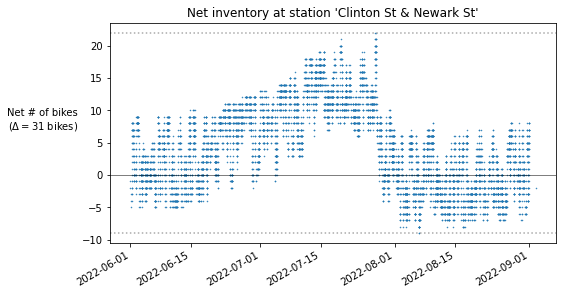

In [99]:
print("Statistical properties of system-wide interarrival times (in minutes):")
netinv = cse6040.utils.load_df_from_file('ex6-netinv.df')
#netinv_example_station = 'Jackson Square'
netinv_example_station = 'Clinton St & Newark St'
netinv_example = netinv[netinv['name'] == netinv_example_station]
cse6040.utils.viz_availability(netinv_example,
                               title=f"Net inventory at station '{netinv_example_station}'",
                               col_avail='netinv',
                               markersize=1)
pass

# Part D: Ad placement #

The city has asked if you can help place advertisements for local businesses and services at various stations. To be more strategic, they want to group—or _cluster_—stations that are commonly visited together. In the next exercise, we'll run try a certain kind of clustering analysis called **spectral clustering**.

A spectral clustering method needs as input a graph (of vertices and connecting edges among them). In the next exercise, you'll construct that input.

## **Exercise 7** (2 pts): `build_edges` ##

To run the spectral clustering algorithm, we first need to construct an edge list. An edge list is a Python list of tuples `(a, b, w)` where `a` is a starting vertex, `b` is the ending vertex, and `w` is a "weight" that measures the importance of that connection.

Complete the function `build_edges(df)` to construct such an edge list from trip statistics computed in Exercise 5. (You did something similar in Midterm 2!)

**Inputs**: The input is a dataframe with the following columns:
- `'start'`: The name of the starting station.
- `'end'`: The name of the ending station.
- `'count'`: The number of times that (start, end) pair occurred.

**Your task**: Construct a Python list of tuples `(a, b, w)` where
- `a` is starting station name
- `b` is the ending station name
- `w` is the original count (`'count'`) divided by the sum of all counts that originate at `a`.

See the demo for an example.

**Output**: Return the Python list of tuples as described above.

**Notes**: There is no ordering requirement; prior to checking your result, we will sort both your output and our expected outputs lexicographically.

In [100]:
### Define demo inputs ###

demo_df_ex7 = cse6040.utils.load_df_from_file('ex7-demo_df_ex7.df')
demo_df_ex7

,start,end,count
0,Montgomery St,11 St & Washington St,1
1,11 St & Washington St,Bergen Ave & Stegman St,1
2,7 St & Monroe St,11 St & Washington St,85
3,Hoboken Ave at Monmouth St,11 St & Washington St,94
4,Southwest Park - Jackson St & Observer Hwy,11 St & Washington St,61
5,11 St & Washington St,Dixon Mills,6
6,Marshall St & 2 St,11 St & Washington St,78
7,11 St & Washington St,Riverview Park,15
8,Stevens - River Ter & 6 St,11 St & Washington St,78
9,11 St & Washington St,Grand St,3


Given the demo input shown above, a correct implementation of `build_edges` would produce the following:

```python
[('11 St & Washington St', 'Bergen Ave & Stegman St', 0.04),
 ('11 St & Washington St', 'Dixon Mills', 0.24),
 ('11 St & Washington St', 'Grand St', 0.12),
 ('11 St & Washington St', 'Riverview Park', 0.6),
 ('7 St & Monroe St', '11 St & Washington St', 1.0),
 ('Hoboken Ave at Monmouth St', '11 St & Washington St', 1.0),
 ('Marshall St & 2 St', '11 St & Washington St', 1.0),
 ('Montgomery St', '11 St & Washington St', 1.0),
 ('Southwest Park - Jackson St & Observer Hwy', '11 St & Washington St', 1.0),
 ('Stevens - River Ter & 6 St', '11 St & Washington St', 1.0)]
```

> _Note:_ This output happens to be sorted, but that is not a requirement.

In [101]:
### Exercise 7 solution
def build_edges(df):
    
    edges = []
    
    a_count = df[['start', 'count']].groupby('start').sum()
    #a_count = df.groupby('start').agg({'count': 'sum'})
    
    for _, row in df.iterrows():
        start = row['start']
        end = row['end']
        count = row['count']
        
        weight = count/a_count.loc[start]['count']
        
        edges.append((start, end, weight))
    
    return edges


#     start_counts = df[['start', 'count']].groupby('start').sum().reset_index() \
#                    .rename(columns={'count': 'outgoing'})
#     edges_df = df.merge(start_counts, on='start')
#     edges_df['weight'] = edges_df['count'] / edges_df['outgoing']
#     edges_df = edges_df[['start', 'end', 'weight']]
#     edges = sorted([(s, e, w) for s, e, w in edges_df.itertuples(index=False)])
#     return edges
    
### demo function call ###
build_edges(demo_df_ex7)

[('Montgomery St', '11 St & Washington St', 1.0),
 ('11 St & Washington St', 'Bergen Ave & Stegman St', 0.04),
 ('7 St & Monroe St', '11 St & Washington St', 1.0),
 ('Hoboken Ave at Monmouth St', '11 St & Washington St', 1.0),
 ('Southwest Park - Jackson St & Observer Hwy', '11 St & Washington St', 1.0),
 ('11 St & Washington St', 'Dixon Mills', 0.24),
 ('Marshall St & 2 St', '11 St & Washington St', 1.0),
 ('11 St & Washington St', 'Riverview Park', 0.6),
 ('Stevens - River Ter & 6 St', '11 St & Washington St', 1.0),
 ('11 St & Washington St', 'Grand St', 0.12)]

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 7. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [102]:
### test_cell_ex7
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_7', 
    'func': lambda df: sorted(build_edges(df)), # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'df':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'list',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## **Run me**: Clustering ##

With a correct implementation of `build_edges`, one can construct a sparse matrix and run the [sklearn spectral clustering method](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html).

We did that for you, constructing three clusters, summarized in the following result:

In [103]:
station_clusters = cse6040.utils.load_obj_from_file("ex7-clustering.array")
station_clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2,
       0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1,
       1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0])

Each element is a station. The value is an integer cluster ID (0, 1, or 2). Of course, this raw clustering result is not very useful. In the next exercise, you'll merge it with the data we have so we can visualize the clusters.

## **Exercise 8** (2 pts): `merge_cluster_info` ##

Complete the function `merge_cluster_info(locs, clusters, stid_to_name)` so that it combines station location and cluster assignment data into a single dataframe for subsequent analysis.

**Inputs**:
- `locs`: A dataframe with three columns:
  * `'name'`: A station name
  * `'lng'`: Its geographic longitude
  * `'lat'`: Its geographic latitude
- `clusters`: A Numpy array of integers, where the station whose ID is `i` is assigned to the cluster whose ID is `clusters[i]`.
- `stid_to_name`: A dictionary mapping each integer station IDs `i` to its station name `stid_to_name[i]`.

**Your task**: The `stid_to_name` dictionary tells you how to map station IDs to names. Using this information, associate each station's location with its cluster ID.

**Output**: Return a new dataframe with the following columns:
- `'name'`: The station name (string)
- `'lng'`: The station's geographic longitude (float)
- `'lat'`: The station's geographic latitude (float)
- `'cluster'`: The station's cluster ID

In [104]:
### Define demo inputs ###
demo_locs_ex8 = cse6040.utils.load_obj_from_file('ex8.locs')
display(demo_locs_ex8)

demo_clusters_ex8 = cse6040.utils.load_obj_from_file('ex8.clusters')
print(demo_clusters_ex8)

demo_stid_to_name_ex8 = cse6040.utils.load_obj_from_file('ex8.stid_to_name')
demo_stid_to_name_ex8

,name,lng,lat
0,JCBS Depot,-74.068601,40.709651
1,Lafayette Park,-74.062857,40.713467
2,Leonard Gordon Park,-74.057263,40.745906
3,Hoboken Terminal - Hudson St & Hudson Pl,-74.030307,40.735937
4,Morris Canal,-74.038515,40.712412
5,South Waterfront Walkway - Sinatra Dr & 1 St,-74.027780,40.736987
6,Columbus Drive,-74.038909,40.718369


[1 1 1 0 1 0 0]


{0: 'Leonard Gordon Park',
 1: 'Morris Canal',
 2: 'Columbus Drive',
 3: 'JCBS Depot',
 4: 'Lafayette Park',
 5: 'South Waterfront Walkway - Sinatra Dr & 1 St',
 6: 'Hoboken Terminal - Hudson St & Hudson Pl'}

A correct implementation of `merge_cluster_info`, run on the demo data above, would produce:

| name                                         |      lng |     lat |   cluster |
|:---------------------------------------------|---------:|--------:|----------:|
| Lafayette Park                               | -74.0629 | 40.7135 |         1 |
| Hoboken Terminal - Hudson St & Hudson Pl     | -74.0303 | 40.7359 |         0 |
| Morris Canal                                 | -74.0385 | 40.7124 |         1 |
| JCBS Depot                                   | -74.0686 | 40.7097 |         0 |
| Columbus Drive                               | -74.0389 | 40.7184 |         1 |
| Leonard Gordon Park                          | -74.0573 | 40.7459 |         1 |
| South Waterfront Walkway - Sinatra Dr & 1 St | -74.0278 | 40.737  |         0 |

For example, observe from the demo inputs that `'Columbus Drive'` is assigned the station ID of `2`. Therefore, its cluster ID is the value `demo_cluster_ex8[2] == 1`. Similarly, `'JCBS Depot'` is assigned the station ID of `3`. Its cluster ID is `demo_cluster_ex8[3] == 0`.

In [105]:
### Exercise 8 solution
def merge_cluster_info(locs, clusters, stid_to_name):
    
    locs2 = locs.copy()
    
    dic = dict(zip(stid_to_name.values(), stid_to_name.keys()))
      
    def func(x):
        
        return clusters[dic[x['name']]]
    
    locs2['cluster'] = locs2.apply(func, axis=1)
    
    return locs2
        

    
#     cdf = pd.DataFrame({'stid': np.arange(len(clusters)),
#                         'cluster': clusters})
#     cdf['name'] = cdf['stid'].apply(stid_to_name.get)
#     return locs.merge(cdf, on=['name']).drop(columns=['stid'])

### demo function call ###
merge_cluster_info(demo_locs_ex8, demo_clusters_ex8, demo_stid_to_name_ex8)

,name,lng,lat,cluster
0,JCBS Depot,-74.068601,40.709651,0
1,Lafayette Park,-74.062857,40.713467,1
2,Leonard Gordon Park,-74.057263,40.745906,1
3,Hoboken Terminal - Hudson St & Hudson Pl,-74.030307,40.735937,0
4,Morris Canal,-74.038515,40.712412,1
5,South Waterfront Walkway - Sinatra Dr & 1 St,-74.027780,40.736987,0
6,Columbus Drive,-74.038909,40.718369,1


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 8. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution. 
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output. 

In [106]:
### test_cell_ex8
###
### AUTOGRADER TEST - DO NOT REMOVE
###
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_8', 
    'func': merge_cluster_info, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'locs':{
            'dtype':'df', # data type of param.
            'check_modified':True,
        },
        'clusters': {
            'dtype': 'array',
            'check_modified': True
        },
        'stid_to_name': {
            'dtype': 'dict',
            'check_modified': True
        }
    },
    'outputs':{
        'output_0':{
            'index':0,
            'dtype':'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'gy_fxnwg2syYRI07RIp8Lm6YY57OL1pZUkVTOC0T43Q=', path='resource/asnlib/publicdata/')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

###
### AUTOGRADER TEST - DO NOT REMOVE
###
print('Passed! Please submit.')

Passed! Please submit.


## Cluster visualization ##

If you had a correct solution to Exercise 8, you would see that the 3-way spectral clustering produced the following grouping of bike stations:

![Bike-station clustering](resource/asnlib/public/station-clustering.png)

**Fin.** If you have made it this far, congratulations on completing the exam. **Don't forget to submit!**